# Self RAG

Self-RAG is a strategy for RAG that incorporates:
- self-reflection
- self grading

In [**the dedicated paper**](https://arxiv.org/abs/2310.11511), a few decisions are made:

1. **Should I retrieve from retriever `R`?**
    - Input: `x (question)` OR `x (question), y (generation)`
    - Decides when to retrieve `D` chunks with `R`
    - Output: `yes, no, continue`

2. **Are the retrieved passages `D` relevant to the question `x`?**
    - Input: `(x (question), d (chunk))` for `d` in `D`
    - Decides if `d` provides useful information to solve `x`
    - Output: `relevant, irrelevant`

3. **Are the LLM generation from each relevant chunk relevant themselves?** (hallucinations, etc)
    - Input: `x (question)`, `d (chunk)`, `y (generation)` for `d` in `D`
    - Decides if all the verification-worthy statements in `y (generation)` are supported by `D`
    - Output: `fully supported, partially supported, no support`

4. **Is the LLM generation from each chunk in `D` a useful response to `x (question)`?**
    - Input: `x (question)`, `y (generation)` for `d` in `D`
    - Decides if `y (generation)` is a useful response to `x (question)`
    - Output: `{5, 4, 3, 2, 1}`

We will implement some of these ideas from scratch using LangGraph, based on the following graph:

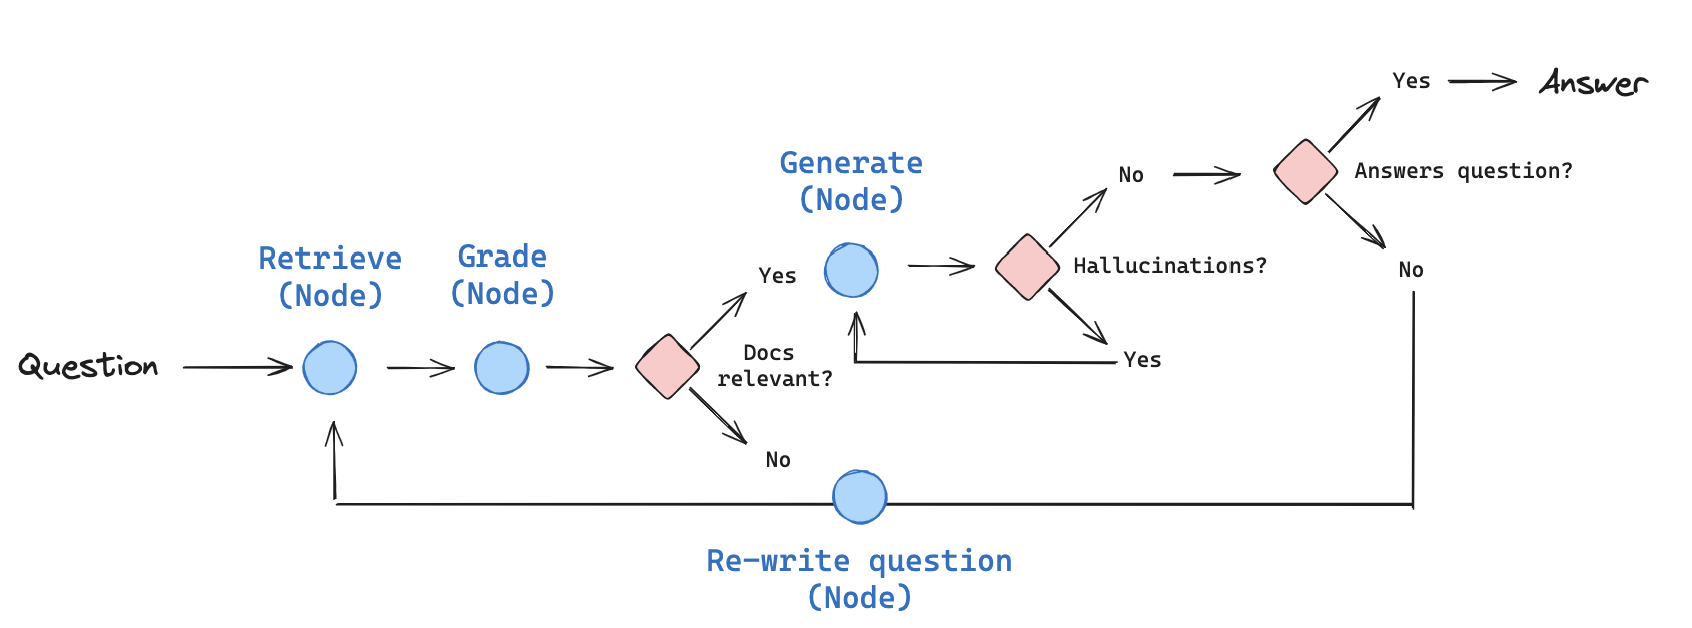


# Setup

In [1]:
from dotenv import load_dotenv

In [2]:
_ = load_dotenv()

In [101]:
# To pretty print outputs
from rich import print as rprint
from rich.console import Console

In [104]:
console = Console()

# Retriever

We will index 3 blog posts related to agents, they're here linked:
- [**Blog post about Agents**](https://lilianweng.github.io/posts/2023-06-23-agent/)
- [**Blog post about Prompt Engineering**](https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/)
- [**Blog post about Adversarial Attacks on LLMs**](https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/)

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

## Load

In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [6]:
docs = [WebBaseLoader(url).load() for url in urls]

> **NOTE**
> 
> `docs` is indeed a list of list that we will flatten.

In [7]:
for idx, doc in enumerate(docs):
    print(idx, f"{type(doc) = } - {len(doc) = }")

0 type(doc) = <class 'list'> - len(doc) = 1
1 type(doc) = <class 'list'> - len(doc) = 1
2 type(doc) = <class 'list'> - len(doc) = 1


In [8]:
docs_list = [item
             for doc in docs
             for item in doc]

In [9]:
len(docs_list), type(docs_list[0])

(3, langchain_core.documents.base.Document)

## Split

In [10]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

In [11]:
docs_splits = text_splitter.split_documents(docs_list)

In [12]:
type(docs_splits), len(docs_splits)

(list, 194)

## Add to Vector DB

In [13]:
vectorstore = Chroma.from_documents(
    documents = docs_splits,
    collection_name = "rag-chroma",
    embedding = OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever()

# LLMs

## Retrieval Grader

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

### Data Model

In [15]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents"""

    binary_score: str = Field(
        description = "Documents are relevant to the question, 'yes' or 'no'"
    )

### LLM With Function Call

In [16]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

### Prompt

In [17]:
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

human = "Retrieved document: \n\n {document} \n\n User question: {question}"

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", human)
])

### Retrieval Chain

In [18]:
retrieval_grader = grade_prompt | structured_llm_grader

### Test

In [19]:
question = "agent memory"
docs = retriever.get_relevant_documents(question)

/home/martin/Documents/LangChainDoc/.venv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [20]:
type(docs), len(docs)

(list, 4)

In [21]:
for idx, doc in enumerate(docs):
    print(f" Chunk {idx} ".center(100, "#"))
    print(doc.page_content)

############################################# Chunk 0 ##############################################
They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to execute the procedure. 7 out of 11 were rejected and among these 7 rejected cases, 5 happened after a Web search while 2 were rejected based on prompt only.
Generative Agents Simulation#
Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.
The design of generative agents combines LLM with memory, planning and reflection mechanisms to

In [22]:
for idx, doc in enumerate(docs):
    doc_txt = doc.page_content
    print(f" Relevance test for chunk {idx} ".center(150, "#"))
    grade = retrieval_grader.invoke({"question": question, "document": doc_txt})
    print("Is the current chunk relevant for the question? ", grade)

############################################################# Relevance test for chunk 0 #############################################################
Is the current chunk relevant for the question?  binary_score='no'
############################################################# Relevance test for chunk 1 #############################################################
Is the current chunk relevant for the question?  binary_score='yes'
############################################################# Relevance test for chunk 2 #############################################################
Is the current chunk relevant for the question?  binary_score='no'
############################################################# Relevance test for chunk 3 #############################################################
Is the current chunk relevant for the question?  binary_score='yes'


## Generate

In [23]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda

### Prompt

> **NOTE**
> 
> Here, we will use a prompt from [**the hub**](https://smith.langchain.com/hub), where many people contribute with sharing valuable prompts for the community.

In [24]:
prompt = hub.pull("rlm/rag-prompt")

In [25]:
from rich import print as rprint

In [26]:
rprint(prompt)

ChatPromptTemplate(
    input_variables=['context', 'question'],
    metadata={
        'lc_hub_owner': 'rlm',
        'lc_hub_repo': 'rag-prompt',
        'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'
    },
    messages=[
        HumanMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=['context', 'question'],
                template="You are an assistant for question-answering tasks. Use the following pieces of retrieved 
context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences 
maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"
            )
        )
    ]
)

### LLM

In [27]:
# Is it mandatory to reinstanciate it?
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

### Post Processing

> **NOTE**
> 
> I don't manage to see the purpose of this function, as it doesn't appear in the current code and even later...

In [28]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Chain

In [29]:
rag_chain = prompt | llm | StrOutputParser()

### Test

In [30]:
generation = rag_chain.invoke({"context": docs, "question": question})
rprint(generation)

The design of generative agents combines LLM with memory, planning, and reflection mechanisms to enable agents to 
behave conditioned on past experience. Long-term memory provides the agent with the capability to retain and recall
infinite information over extended periods. Short-term memory is utilized for in-context learning.

## Hallucination Grader

### Data Model

In [31]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description = "Answer is grounded in the facts, 'yes' or 'no'"
    )

### LLM With Function Call

In [32]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

### Prompt

In [33]:
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

human = "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"

hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", human)
])

### Hallucination Chain

In [34]:
hallucination_grader = hallucination_prompt | structured_llm_grader

### Test

In [35]:
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## Answer Grader

### Data Model

In [36]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description = "Answer addresses the question, 'yes' or 'no'"
    )

### LLM With Function Call

In [37]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

### Prompt

In [38]:
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

human = "User question: \n\n {question} \n\n LLM generation: {generation}"

answer_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", human)
])

### Answer Grading Chain

In [39]:
answer_grader = answer_prompt | structured_llm_grader

### Test

In [40]:
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## Question Re-writer

### LLM

In [41]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

### Prompt

In [42]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

human = "Here is the initial question: \n\n {question} \n Formulate an improved question."

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", human)
])

### Rewrite Chain

In [43]:
question_rewriter = re_write_prompt | llm | StrOutputParser()

### Test

In [44]:
question_rewriter.invoke({"question": question})

"What is the role of memory in an agent's functioning?"

# Graph

Capture the flow in as a graph

In [45]:
from typing import List
from typing_extensions import TypedDict

In [46]:
class GraphState(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

## Nodes

### Retrieve

In [47]:
def retrieve(state: GraphState) -> GraphState:
    """
    Retrieve documents.

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print(" RETRIEVE ".center(100, "-"))
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {
        "question": question,
        "documents": documents,
    }

### Generate

In [48]:
def generate(state: GraphState) -> GraphState:
    """
    Generate answer.

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print(" GENERATE ".center(100, "-"))
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "question": question,
        "documents": documents,
        "generation": generation
    }

### Grade Documents

In [95]:
def grade_documents(state: GraphState) -> GraphState:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print(" CHECK RELEVANCE TO QUESTION ".center(100, "-"))
    question = state["question"]
    documents = state["documents"]

    # Score each document
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            rprint(" GRADE: DOCUMENT IS RELEVANT ".center(100, "-"))
            filtered_docs.append(d)
        else:
            print(" GRADE: DOCUMENT IS NOT RELEVANT ".center(100, "-"))
            continue  # Optional but meaningful

    return {
        "question": question,
        "documents": filtered_docs
    }

### Transform Query

In [50]:
def transform_query(state: GraphState) -> GraphState:
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print(" TRANSFORM QUERY ".center(100, "-"))
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {
        "question": better_question,
        "documents": documents
    }

## Conditional Edges

### Decide To Generate

In [111]:
def decide_to_generate(state: GraphState) -> str:
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call 
    """
    print(" ASSESS GRADED DOCUMENTS ".center(100, "-"))
    filtered_documents = state["documents"]

    if not filtered_documents:
        # No document has been found relevant
        # We will re-generate a new query
        print(" DECISION: NO DOCUMENT IS RELEVANT TO QUERY ".center(100, "-"))
        return "transform_query"
    else:
        # There are relevant documents
        print(" DECISION: GENERATE ".center(100, "-"))
        return "generate"

### Grade Generation VS Documents And Question

In [52]:
def grade_generation_vs_documents_and_question(state: GraphState) -> str:
    """
    Determines whether the generation:
    - is grounded in the documents,
    - answers question.

    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for the next node to call
    """
    print(" CHECK HALLUCINATIONS ".center(100, "-"))
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucinations
    if grade == "yes":
        print(" DECISION: GENERATION IS GROUNDED IN DOCUMENTS ".center(100, "-"))
        # Check question answering
        print(" GRADE GENERATION VS QUESTION ".center(100, "-"))
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print(" DECISION: GENERATION ADDRESSES QUESTION ".center(100, "-"))
            return "useful"
        else:
            print(" DECSION: GENERATION DOES NOT ADDRESS QUESTION ".center(100, "-"))
            return "not_useful"
    else:
        print(" DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS ".center(100, "-"))
        return "not supported"

## Build Graph

In [53]:
from langgraph.graph import END, StateGraph

In [63]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build Graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",  # Starting node
    decide_to_generate,  # Decision function
    # Map outputs of decision function to destination node's name
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_vs_documents_and_question,
    {
        "not supported": "generate",
        "not useful": "transform_query",
        "useful": END
    }
)

# Compile
app = workflow.compile()


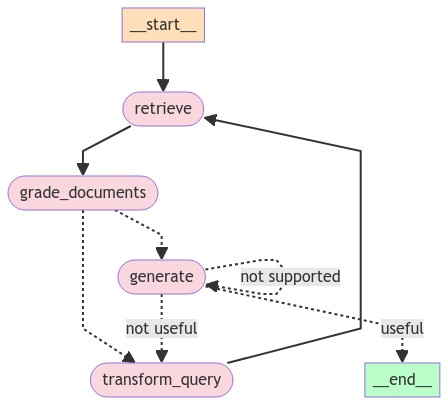

In [64]:
from IPython.display import Image

Image(app.get_graph(xray=True).draw_mermaid_png())

# Global Tests

## First

In [110]:
# Run
inputs = {"question": "Explain how the different types of agent memory work"}

for output in app.stream(inputs):
    for key, value in output.items():
        rprint(f" NODE '{key}'".center(100, "="))
        console.print(f"[bold cyan]question:\n{value['question']}")
    print("\n" + "=" * 100 + "\n")

# Final Generation
console.print(f"[bold cyan]Answer:\n{value['generation']}")   

--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question:
Explain how the different types of agent memory work



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------------------- DECISION: GENERATE ----------------------------------------


====================================== NODE 'grade_documents'=======================================

question:
Explain how the different types of agent memory work



--------------------------------------------- GENERATE ---------------------------------------------
--------------------------------------- CHECK HALLUCINATIONS ---------------------------------------
-------------------------- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---------------------------
----------------------------------- GRADE GENERATION VS QUESTION -----------------------------------
----------------------------- DECISION: GENERATION ADDRESSES QUESTION ------------------------------


========================================== NODE 'generate'==========================================

question:
Explain how the different types of agent memory work

Answer:
Short-term memory in agents is used for in-context learning, such as in Prompt Engineering. Long-term memory allows
agents to retain and recall infinite information over extended periods by leveraging external vector stores. Agents
can also use external APIs to access additional information not present in their model weights.

## Second

In [77]:
# Run
inputs = {"question": "Drawbacks on prompt engineering"}

for output in app.stream(inputs):
    for key, value in output.items():
        rprint(f" NODE '{key}'".center(100, "="))
        rprint("question:", value["question"])
    print("\n" + "=" * 100 + "\n")

# Final Generation
rprint(value["generation"])   

--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: Drawbacks on prompt engineering



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------------------- DECISION: GENERATE ----------------------------------------


====================================== NODE 'grade_documents'=======================================

question: Drawbacks on prompt engineering



--------------------------------------------- GENERATE ---------------------------------------------
--------------------------------------- CHECK HALLUCINATIONS ---------------------------------------
-------------------------- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---------------------------
----------------------------------- GRADE GENERATION VS QUESTION -----------------------------------
----------------------------- DECISION: GENERATION ADDRESSES QUESTION ------------------------------


========================================== NODE 'generate'==========================================

question: Drawbacks on prompt engineering

The drawbacks of prompt engineering include the need for heavy experimentation and heuristics due to varying 
effects among models. Some papers on prompt engineering may be unnecessarily lengthy, focusing more on benchmarking
than on concise explanations of tricks. Setting up iterative prompting or external tools and aligning the research 
community to adopt them can also be non-trivial tasks.

## Third

In [78]:
# Run
inputs = {"question": "Is ChatGPT an LLM?"}

for output in app.stream(inputs):
    for key, value in output.items():
        rprint(f" NODE '{key}'".center(100, "="))
        rprint("question:", value["question"])
    print("\n" + "=" * 100 + "\n")

# Final Generation
rprint(value["generation"])   

--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: Is ChatGPT an LLM?



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------------------- DECISION: GENERATE ----------------------------------------


====================================== NODE 'grade_documents'=======================================

question: Is ChatGPT an LLM?



--------------------------------------------- GENERATE ---------------------------------------------
--------------------------------------- CHECK HALLUCINATIONS ---------------------------------------
-------------------------- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---------------------------
----------------------------------- GRADE GENERATION VS QUESTION -----------------------------------
----------------------------- DECISION: GENERATION ADDRESSES QUESTION ------------------------------


========================================== NODE 'generate'==========================================

question: Is ChatGPT an LLM?

Yes, ChatGPT is an LLM (large language model) as its core controller. It functions as the agent's brain in 
autonomous agent systems, complemented by other key components. The potential of LLM extends beyond generating 
copies, stories, and essays to being a powerful general problem solver.

## Fourth

In [79]:
# Run
inputs = {"question": "GPT LLM?"}

for output in app.stream(inputs):
    for key, value in output.items():
        rprint(f" NODE '{key}'".center(100, "="))
        rprint("question:", value["question"])
    print("\n" + "=" * 100 + "\n")

# Final Generation
rprint(value["generation"])   

--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: GPT LLM?



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------------------- DECISION: GENERATE ----------------------------------------


====================================== NODE 'grade_documents'=======================================

question: GPT LLM?



--------------------------------------------- GENERATE ---------------------------------------------
--------------------------------------- CHECK HALLUCINATIONS ---------------------------------------
-------------------------- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---------------------------
----------------------------------- GRADE GENERATION VS QUESTION -----------------------------------
----------------------------- DECISION: GENERATION ADDRESSES QUESTION ------------------------------


========================================== NODE 'generate'==========================================

question: GPT LLM?

GPT LLM refers to using large language models like GPT-4 as the core controller for autonomous agents. These agents
can handle tasks like planning, subgoal decomposition, reflection, and refinement with the LLM functioning as the 
brain. However, there are potential challenges in using LLMs to evaluate their own performance in domains requiring
deep expertise.

## Fifth

In [80]:
# Run
inputs = {"question": "Anthropic GPT agent tools"}

for output in app.stream(inputs):
    for key, value in output.items():
        rprint(f" NODE '{key}'".center(100, "="))
        rprint("question:", value["question"])
    print("\n" + "=" * 100 + "\n")

# Final Generation
rprint(value["generation"])   

--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: Anthropic GPT agent tools



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------- DECISION: NO DOCUMENT IS RELEVANT TO QUERY ----------------------------


====================================== NODE 'grade_documents'=======================================

question: Anthropic GPT agent tools



----------------------------------------- TRANSFORM QUERY ------------------------------------------


====================================== NODE 'transform_query'=======================================

question: What are the tools available for creating anthropic GPT agents?



--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: What are the tools available for creating anthropic GPT agents?



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------------------- DECISION: GENERATE ----------------------------------------


====================================== NODE 'grade_documents'=======================================

question: What are the tools available for creating anthropic GPT agents?



--------------------------------------------- GENERATE ---------------------------------------------
--------------------------------------- CHECK HALLUCINATIONS ---------------------------------------
-------------------------- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---------------------------
----------------------------------- GRADE GENERATION VS QUESTION -----------------------------------
----------------------------- DECISION: GENERATION ADDRESSES QUESTION ------------------------------


========================================== NODE 'generate'==========================================

question: What are the tools available for creating anthropic GPT agents?

The tools available for creating anthropic GPT agents include AutoGPT and GPT-Engineer, as mentioned in the 
provided context. These tools serve as proof-of-concepts demos for building agents with large language models as 
their core controllers. The potential of large language models extends beyond generating content to being powerful 
general problem solvers.

## Reflection

`temperature` different from 0 doesn't guarantee totally deterministic flows and answers.

In [81]:
# Run
inputs = {"question": "Anthropic GPT agent tools"}

for output in app.stream(inputs):
    for key, value in output.items():
        rprint(f" NODE '{key}'".center(100, "="))
        rprint("question:", value["question"])
    print("\n" + "=" * 100 + "\n")

# Final Generation
rprint(value["generation"])   

--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: Anthropic GPT agent tools



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------- DECISION: NO DOCUMENT IS RELEVANT TO QUERY ----------------------------


====================================== NODE 'grade_documents'=======================================

question: Anthropic GPT agent tools



----------------------------------------- TRANSFORM QUERY ------------------------------------------


====================================== NODE 'transform_query'=======================================

question: What are the tools available for creating anthropic GPT agents?



--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: What are the tools available for creating anthropic GPT agents?



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------- DECISION: NO DOCUMENT IS RELEVANT TO QUERY ----------------------------


====================================== NODE 'grade_documents'=======================================

question: What are the tools available for creating anthropic GPT agents?



----------------------------------------- TRANSFORM QUERY ------------------------------------------


====================================== NODE 'transform_query'=======================================

question: What tools can be used to develop anthropic GPT agents?



--------------------------------------------- RETRIEVE ---------------------------------------------


========================================== NODE 'retrieve'==========================================

question: What tools can be used to develop anthropic GPT agents?



----------------------------------- CHECK RELEVANCE TO QUESTION ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
----------------------------------- GRADE: DOCUMENT IS RELEVANT ------------------------------------
--------------------------------- GRADE: DOCUMENT IS NOT RELEVANT ----------------------------------
------------------------------------- ASSESS GRADED DOCUMENTS --------------------------------------
---------------------------------------- DECISION: GENERATE ----------------------------------------


====================================== NODE 'grade_documents'=======================================

question: What tools can be used to develop anthropic GPT agents?



--------------------------------------------- GENERATE ---------------------------------------------
--------------------------------------- CHECK HALLUCINATIONS ---------------------------------------
-------------------------- DECISION: GENERATION IS GROUNDED IN DOCUMENTS ---------------------------
----------------------------------- GRADE GENERATION VS QUESTION -----------------------------------
----------------------------- DECISION: GENERATION ADDRESSES QUESTION ------------------------------


========================================== NODE 'generate'==========================================

question: What tools can be used to develop anthropic GPT agents?

Tools such as AutoGPT, GPT-Engineer, and BabyAGI can be used to develop anthropic GPT agents. These tools leverage 
large language models (LLM) as the core controller for the agents, allowing them to function as powerful general 
problem solvers. In addition to LLM, key components like planning, subgoal decomposition, reflection, and 
refinement are essential for developing these agents.